Triplet Encoder (Pretrained) --> Triplet Embedding --> Latent Space Mapping --> Decoder (Pretrained) 

In [6]:
import scripts.init_gpu as init_gpu
import scripts.init_dataset as init_dataset
from scripts.triplet_functions import n_neurons
import pandas as pd

init_gpu.initialize_gpus()

locations = ['LOC1', 'LOC2']

print("Loading Dataset...")
# load the dataset
df = pd.read_csv(
    f"../dataset/processed/{locations[0]}-{locations[1]}-scaled-balanced.csv")

length = len(df.columns) - 2  # subtract the two label columns

# get train-test set
train_df, test_df, train_web_samples, test_web_samples = init_dataset.get_sample(
    df, locations, range(1500), 1200)

train_df.head()

Num GPUs Available:  2
Loading Dataset...
Training Websites: [1309, 228, 51, 563, 501, 457, 285, 209, 1385, 1116, 178, 1209, 864, 65, 61, 191, 447, 476, 1034, 1232, 54, 1149, 407, 1466, 1330, 1436, 1490, 859, 451, 919, 1206, 569, 13, 326, 1429, 865, 696, 1468, 318, 440, 689, 1492, 189, 778, 198, 735, 704, 1236, 541, 88, 940, 1098, 255, 775, 161, 1130, 600, 1287, 1266, 740, 1182, 393, 142, 93, 1354, 466, 592, 163, 1482, 206, 1456, 1462, 928, 1301, 747, 333, 758, 727, 429, 1372, 546, 1399, 1327, 146, 1247, 1300, 350, 1093, 1495, 334, 946, 777, 552, 1310, 1140, 449, 1402, 664, 114, 469, 1486, 646, 821, 548, 135, 432, 1161, 644, 435, 1342, 1022, 810, 1316, 939, 292, 542, 1493, 505, 1478, 1103, 538, 1197, 877, 1195, 817, 741, 1404, 283, 1043, 1010, 186, 96, 224, 313, 1285, 327, 1487, 1221, 130, 788, 781, 1220, 958, 1083, 514, 1133, 23, 234, 1099, 1419, 1312, 1463, 1498, 601, 890, 323, 929, 6, 539, 1025, 365, 1039, 217, 1280, 611, 1308, 1338, 1415, 1477, 1366, 765, 330, 1104, 1086, 1, 1226, 

/home/asil0892/doh_traffic_analysis/code/scripts/init_dataset.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=["Location"], inplace=True)


,Location,Website,0,1,2,3,4,5,6,7,...,116,117,118,119,120,121,122,123,124,125
0,LOC1,0,-1.086861,0.690199,0.647933,0.201517,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
1,LOC1,1005,1.095547,-1.585943,0.647933,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
2,LOC1,1005,1.095547,0.780047,-1.972790,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
3,LOC1,1005,-1.086861,0.690199,0.647933,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
4,LOC1,1005,1.095547,0.780047,0.183501,-0.828965,-2.083179,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604


In [39]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from scripts.train_vae import VAE, Sampling


class TripletToLatentAlignment(keras.Model):
    def __init__(self, triplet_dim, latent_dim, **kwargs):
        """
        Args:
            input_dim: Dimension of input latent space (input_vae's latent dim)
            hidden_dims: List of hidden layer dimensions
        """
        super(TripletToLatentAlignment, self).__init__(**kwargs)

        self.input_dim = triplet_dim
        self.alignment_network = keras.Sequential([
            keras.layers.InputLayer(input_shape=(triplet_dim,)),
            keras.layers.Dense(triplet_dim, activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),
            keras.layers.RepeatVector(1),
            keras.layers.GRU(latent_dim),
            keras.layers.Dense(
                units=latent_dim * 2,
                activation='relu',
            ),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),

            # # Second dense layer
            # keras.layers.Dense(
            #     units=latent_dim * 2,
            #     activation='relu',
            # ),
            # keras.layers.BatchNormalization(),
            # keras.layers.Dropout(0.1),
            # # Output both mean and log variance
            keras.layers.Dense(latent_dim * 2, activation=None)
        ])

    def call(self, inputs):
        x = self.alignment_network(inputs)
        mean, log_var = tf.split(x, num_or_size_splits=2, axis=1)
        return mean, log_var

    def get_config(self):
        config = super(TripletToLatentAlignment, self).get_config()
        config.update({
            "input_dim": self.input_dim,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class TripletToLatent:
    def __init__(self, pretrained_vae, triplet_model, alignment_network, kl_weight=0.01, latent_weight=1):
        """
        Args:
            input_vae: Source domain VAE (fixed)
            output_vae: Target domain VAE (fixed)
            alignment_network: Network to align latent spaces
            kl_weight: Weight for the KL divergence loss term
        """
        self.pretrained_vae = pretrained_vae
        self.alignment_network = alignment_network
        self.kl_weight = kl_weight
        self.triplet_model = triplet_model
        self.latent_weight = latent_weight
        self.sampling = Sampling()
        self.pretrained_vae.trainable = False
        self.triplet_model.trainable = False

    @tf.function
    def train_step(self, x, optimizer):
        """Single training step with KL divergence loss
        Args:
            x_source: Input data from source domain
            x_target: Corresponding data from target domain
            optimizer: Keras optimizer
        """
        with tf.GradientTape() as tape:
            # Encode source and target data
            z_mean, z_log_var, z = self.pretrained_vae.encode(x)
            x_triplet_embedding = self.triplet_model(x)
            # Transform latent representation and get distribution parameters
            aligned_mean, aligned_log_var = self.alignment_network(
                x_triplet_embedding)
            kl_loss = -0.5 * \
                tf.reduce_mean(1 + aligned_log_var -
                               tf.square(aligned_mean) - tf.exp(aligned_log_var))

            # Sample from the aligned distribution
            aligned_z = self.sampling((aligned_mean, aligned_log_var))

            # Decode to target domain
            x_generated = self.pretrained_vae.decode(aligned_z)

            # Compute reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(x - x_generated))

            # latent space loss
            latent_loss = tf.reduce_mean(tf.square(z_mean - aligned_mean))

            # Total loss
            loss = reconstruction_loss + self.kl_weight * \
                kl_loss + self.latent_weight * latent_loss

        # Update alignment network
        grads = tape.gradient(loss, self.alignment_network.trainable_variables)
        optimizer.apply_gradients(
            zip(grads, self.alignment_network.trainable_variables))

        return loss, kl_loss, reconstruction_loss, latent_loss

    def train(self, train_dataset, optimizer, epochs):
        """Train the domain adapter
        Args:
            train_dataset: tf.data.Dataset containing (x_source, x_target) pairs
            optimizer: Keras optimizer
            epochs: Number of training epochs
        """
        for epoch in range(epochs):
            total_loss = 0
            total_kl_loss = 0
            total_reconstruction_loss = 0
            total_latent_loss = 0
            num_batches = 0

            for x in train_dataset:
                loss, kl_loss, reconstruction_loss, latent_loss = self.train_step(
                    x, optimizer)
                total_loss += float(loss)
                total_kl_loss += float(kl_loss)
                total_reconstruction_loss += float(reconstruction_loss)
                total_latent_loss += float(latent_loss)
                num_batches += 1

            # Calculate average losses
            avg_loss = total_loss / num_batches
            avg_kl_loss = total_kl_loss / num_batches
            avg_reconstruction_loss = total_reconstruction_loss / num_batches
            avg_latent_loss = total_latent_loss / num_batches
            print(f"Epoch {epoch+1}, Total Loss: {avg_loss:.4f}")
            print(
                f"\tKL Loss: {avg_kl_loss:.4f}, Reconstruction Loss: {avg_reconstruction_loss:.4f}, Latent Eucl Dist: {avg_latent_loss:.4f}")

    @tf.function
    def transform(self, x):
        """Transform source domain data to target domain
        Args:
            x_source: Input data from source domain
        Returns:
            Generated data in target domain
        """
        x_triplet_embedding = self.triplet_model(x)
        aligned_mean, aligned_log_var = self.alignment_network(
            x_triplet_embedding)
        aligned_z = self.sampling((aligned_mean, aligned_log_var))

        return self.pretrained_vae.decode(aligned_z)

In [ ]:
from scripts.train_vae import filter_and_sort_data, VAE

location = 'LOC1'
X_train = filter_and_sort_data(train_df, location).to_numpy().astype('float32')


# Load your pre-trained VAEs
pretrained_vae = tf.keras.models.load_model(f"../models/vae/{location}-e400-mse1-kl0.01.keras", custom_objects={'VAE': VAE, 'Sampling': Sampling})
web_model = tf.keras.models.load_model(f"../models/website/{locations[0]}-{locations[1]}-baseGRU-epochs200-train_samples1200-triplet_samples5.keras")
# Create alignment network
alignment_network = TripletToLatentAlignment(
    32, 32,  # Should match VAE latent_dim
)

# Create domain adapter
adapter = TripletToLatent(pretrained_vae, web_model, alignment_network, kl_weight=0.01, latent_weight=1)

# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train)
).shuffle(buffer_size=10000).batch(32)

# Train adapter
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
adapter.train(train_dataset, optimizer, epochs=100)

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_501. Received: the structure of inputs=['*', '*']
  warnings.warn(


In [44]:
X_test = filter_and_sort_data(test_df, location).to_numpy().astype('float32')
synthesized = adapter.transform(X_test).numpy()

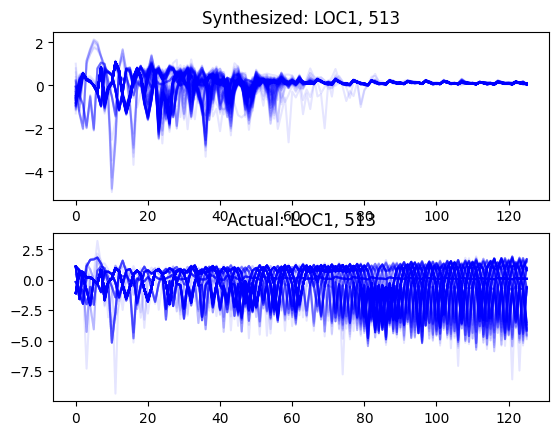

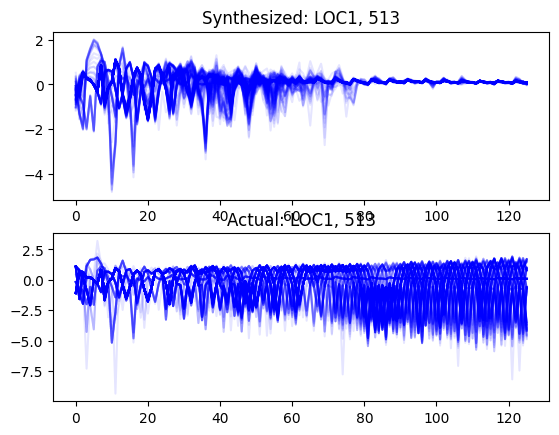

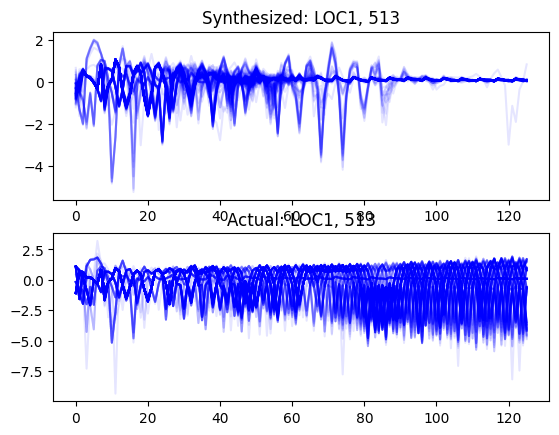

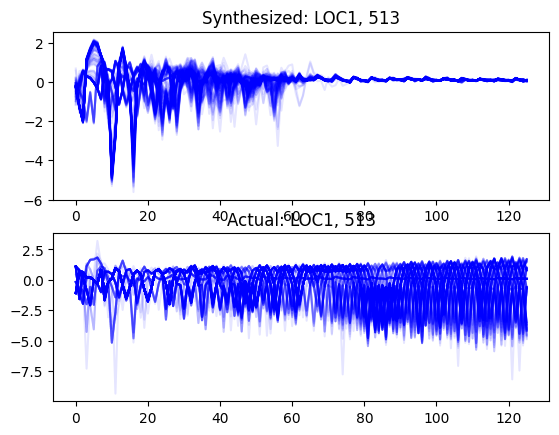

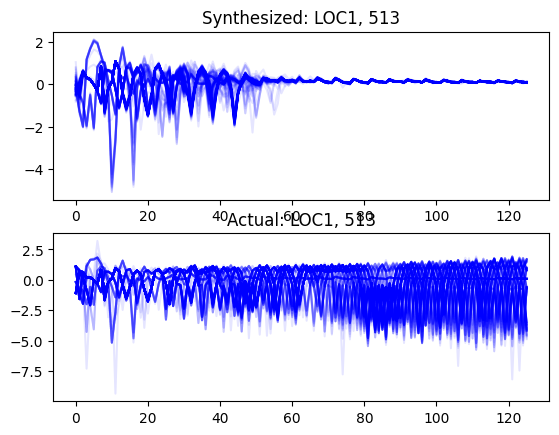

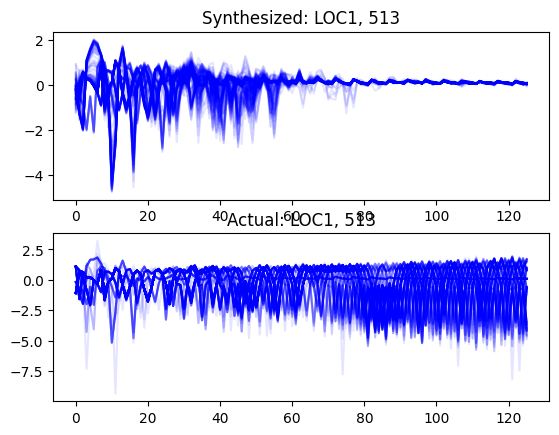

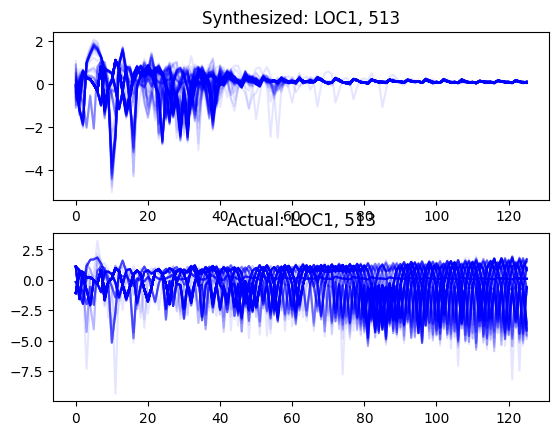

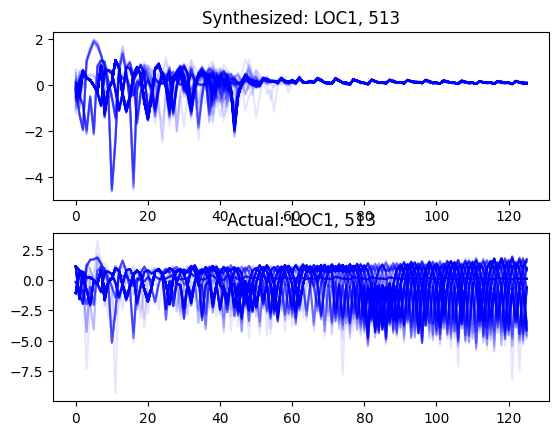

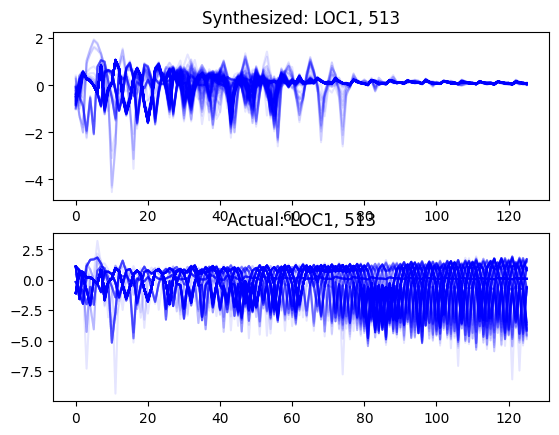

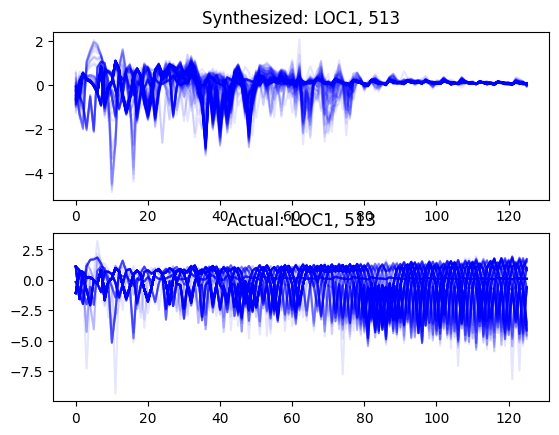

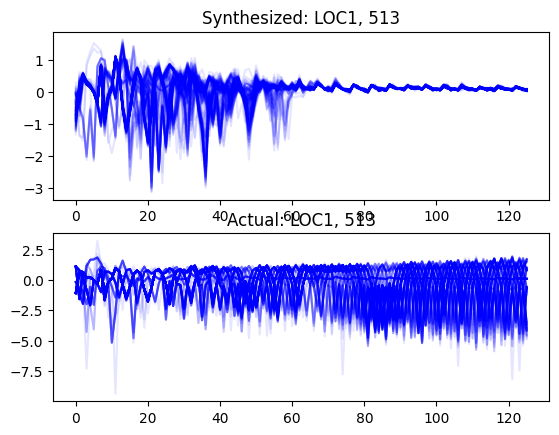

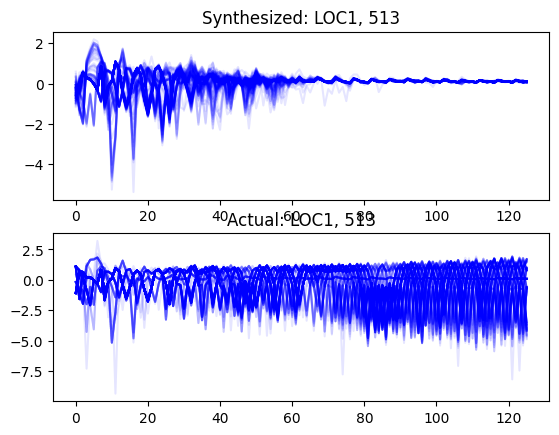

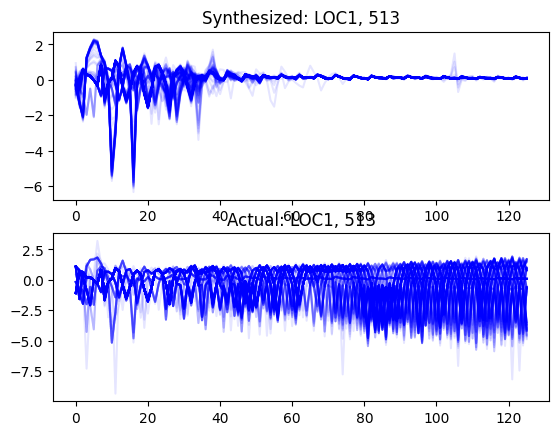

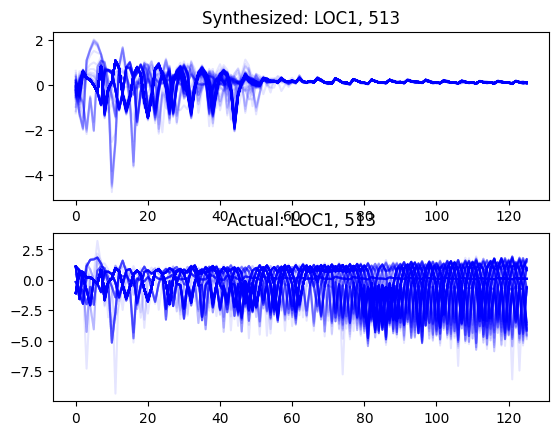

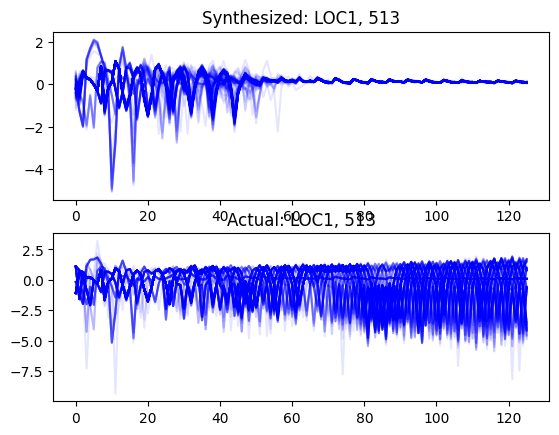

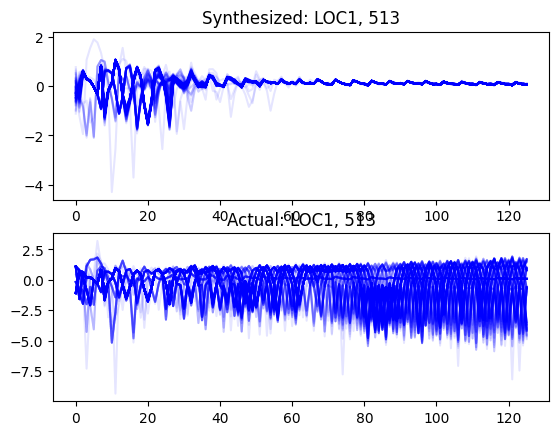

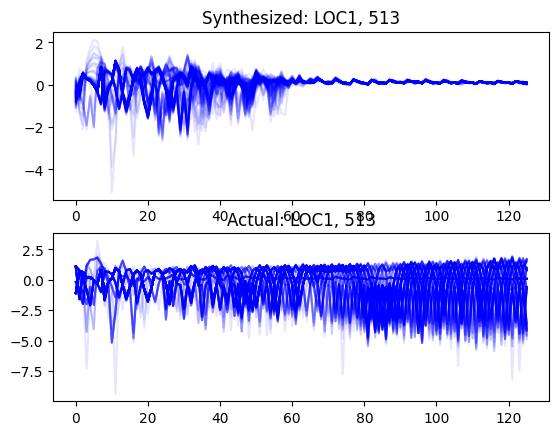

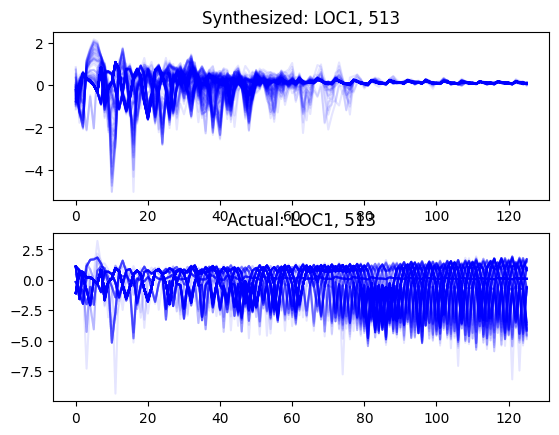

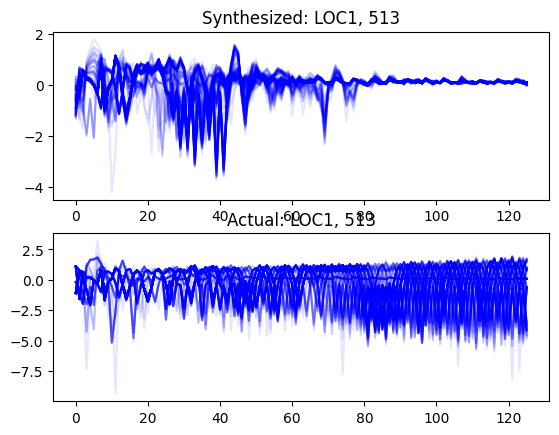

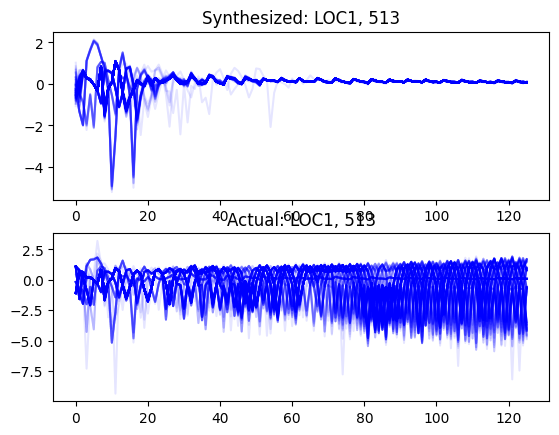

In [47]:
import matplotlib.pyplot as plt

for i in range(0, 200 * 20, 200):

    plt.figure()

    plt.subplot(2, 1, 1)
    traces = synthesized[i:i+200]
    for i in range(200):
        plt.plot(traces[i], alpha=0.1, c='b')
    plt.title(f"Synthesized: {location}, {test_web_samples[i // 200]}")

    plt.subplot(2, 1, 2)
    traces = X_test[i:i+200]
    for i in range(200):
        plt.plot(traces[i], alpha=0.1, c='b')
    plt.title(f"Actual: {location}, {test_web_samples[i // 200]}")

    plt.show()



In [5]:
# import tensorflow as tf
# from tensorflow import keras
# import numpy as np
# from scripts.train_vae import Sampling, VAE, filter_and_sort_data

# def vae_loss(inputs, reconstructed, z_mean, z_log_var):
#     mse_loss = tf.reduce_mean(tf.square(inputs - reconstructed))
#     kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#     total_loss = mse_loss + 0.01 * kl_loss
#     # tf.print("MSE Loss:", mse_loss, "KL Loss:", kl_loss, "Total Loss:", total_loss)

#     return total_loss

# @tf.function
# def train_step(model, x, y,optimizer):
#     with tf.GradientTape() as tape:
#         reconstructed, z_mean, z_log_var = model(x)
#         loss = vae_loss(y, reconstructed, z_mean, z_log_var)
#     grads = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(grads, model.trainable_variables))
#     # Print statement for debugging
#     # tf.print("Loss:", loss)
#     return loss

# def train_vae(model, train_dataset, optimizer, epochs):
#     for epoch in range(epochs):
#         epoch_loss = tf.keras.metrics.Mean()
#         for step, (x, y) in enumerate(train_dataset):
#             loss = train_step(model, x, y, optimizer)
#             epoch_loss.update_state(loss)
#         print(f"Epoch {epoch+1}, Loss: {epoch_loss.result():.4f}")

# LOC2_vae = tf.keras.models.load_model("../models/vae/LOC2-e400-mse1-kl0.01.keras", custom_objects={'VAE': VAE, 'Sampling': Sampling})
# LOC2_vae.trainable = False

In [ ]:
# from tensorflow.keras import regularizers

# input_dim = length
# latent_dim = 32
# hidden_dim = 64
# triplet_to_vae = VAE(input_dim, latent_dim, hidden_dim)

# dropout_rate = 0.3
# triplet_to_vae.encoder = keras.Sequential([
#     keras.layers.InputLayer(input_shape=(latent_dim,)),
#     keras.layers.Dense(
#         units=latent_dim * 2,
#         activation='relu',
#     ),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(dropout_rate),

#     # Second dense layer
#     keras.layers.Dense(
#         units=latent_dim * 2,
#         activation='relu',
#     ),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(dropout_rate),

#     # Third dense layer reducing dimensions
#     keras.layers.Dense(
#         units=latent_dim,
#         activation='relu',
#     ),
#     keras.layers.BatchNormalization(),
#     # Lower dropout rate as we approach output
#     keras.layers.Dropout(dropout_rate/2),

#     # Output layer matching input dimensions
#     keras.layers.Dense(
#         units=latent_dim,
#         activation='linear'  # Linear activation for output
#     )
# ])



# triplet_to_vae.decoder = LOC2_vae.decoder
# triplet_to_vae.decoder.trainable = False

In [9]:
web_model = tf.keras.models.load_model(f"../models/website/{locations[0]}-{locations[1]}-baseGRU-epochs300-train_samples1200-triplet_samples5.keras")
web_model.trainable = False

In [ ]:
# import pandas as pd

# sampling_location = 'LOC2'
# target_location = 'LOC2'
# X_train = []
# chunk_size = 10000

# # for i in range(0, 240000, chunk_size):
# #     chunk = filter_and_sort_data(train_df[i:i+chunk_size], sampling_location)
    
# #     # Pad the chunk if it's smaller than chunk_size
# #     if len(chunk) < chunk_size:
# #         chunk = chunk.reindex(range(chunk_size), fill_value=0)
    
# #     transformed_chunk = web_model(chunk)
# #     X_train.append(transformed_chunk)


# for i in range(0, 240000, chunk_size):
#     chunk = filter_and_sort_data(train_df[i:i+chunk_size], target_location)
    
#     # Pad the chunk if it's smaller than chunk_size
#     if len(chunk) < chunk_size:
#         chunk = chunk.reindex(range(chunk_size), fill_value=0)
    
#     transformed_chunk = web_model(chunk)
#     X_train.append(transformed_chunk)
    
    
# # Combine all chunks into one dataset
# X_train = np.vstack(X_train)  # Or use `tf.concat(X_train, axis=0)` for tensors
# y_train = filter_and_sort_data(train_df, target_location).to_numpy().astype('float32')

2024-10-31 11:46:28.569361: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


In [ ]:
# y_train = np.repeat(y_train, 2, axis=0)

In [ ]:
# # Initialize optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_dataset = train_dataset.shuffle(buffer_size=10000).batch(128)



# # Train the model
# train_vae(triplet_to_vae, train_dataset, optimizer, epochs=400)

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias', 'kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
2024-10-31 11:47:02.106036: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 0.9069


2024-10-31 11:47:31.570480: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.9029
Epoch 3, Loss: 0.9027


2024-10-31 11:48:24.498128: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.9027
Epoch 5, Loss: 0.9027
Epoch 6, Loss: 0.9027
Epoch 7, Loss: 0.9027


2024-10-31 11:50:20.089812: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Loss: 0.9027


KeyboardInterrupt: 